# XGBOOST

### Import Libraries

In [24]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import Imputer
from sklearn.metrics import auc
from matplotlib import pyplot as plt

%matplotlib inline


pd.set_option('display.max_columns', None)

### Import Dataset

In [35]:
df = pd.read_csv("../EDA/merged_w_state_build_2017-05-30.csv",  parse_dates=['timestamp'], index_col=False, low_memory=False)

In [36]:
np.sum(df['price_doc_log'].isnull())

7662

### Select Features

In [74]:
features = ['floor', 'full_sq^2', 'area_km', 'density','month','year','age_log',
            'rel_floor', 'material', 'num_room', 'work_share','kitch_sq', 'state', 'product_type',
            'sub_area', 'indust_part', 'sport_objects_raion', 'metro_min_avto',
            'green_zone_km', 'industrial_km', 'kremlin_km', 'radiation_km', 'ts_km', 'fitness_km',
            'stadium_km', 'park_km', 'price_doc_log']

### Transform some Features

In [75]:
np.sum(df['price_doc_log'].isnull())
# np.sum(df['full_sq^2'].isnull())

7662

In [76]:
df['age_log'] = np.log1p(df['age'])
df.loc[df['full_sq^2'].isnull(), 'full_sq^2'] = np.median(df.loc[df['full_sq^2'].notnull(),'full_sq^2'])
df.loc[df['rel_floor'].isnull(), 'rel_floor'] = np.median(df.loc[df['rel_floor'].notnull(),'rel_floor'])

Exception AttributeError: "'DMatrix' object has no attribute 'handle'" in <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x115e4a650>> ignored


KeyError: 'age'

In [77]:
for feature in features:
    if np.sum(df[feature].isnull()) > 0:
        print feature,np.sum(df[feature].isnull())

price_doc_log 7662


In [78]:
df.shape

(37659, 28)

In [79]:
# df = df.select_dtypes(exclude=['datetime'])
df = df[features]

y_train = df.loc[df['price_doc_log'].notnull(), 'price_doc_log']
X_train = df.loc[df['price_doc_log'].notnull(), df.columns != 'price_doc_log']
X_test = df.loc[df['price_doc_log'].isnull(), df.columns != 'price_doc_log']

print y_train.shape, X_train.shape, X_test.shape

(29997,) (29997, 26) (7662, 26)


## Selecting Features

In [80]:
import xgboost as xgb

xgb_params = {
    'eta': 0.02,
    'max_depth': 10,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

dtrain = xgb.DMatrix(X_train, y_train, feature_names=X_train.columns)
dtest = xgb.DMatrix(X_test, feature_names=X_test.columns)


cv_result = xgb.cv(xgb_params, dtrain, num_boost_round=1000, 
                   early_stopping_rounds=20, verbose_eval=True, show_stdv=False)

[0]	train-rmse:14.8171	test-rmse:14.8172
[1]	train-rmse:14.5213	test-rmse:14.5213
[2]	train-rmse:14.2313	test-rmse:14.2313
[3]	train-rmse:13.9472	test-rmse:13.9472
[4]	train-rmse:13.6687	test-rmse:13.6688
[5]	train-rmse:13.3959	test-rmse:13.3959
[6]	train-rmse:13.1285	test-rmse:13.1285
[7]	train-rmse:12.8664	test-rmse:12.8665
[8]	train-rmse:12.6096	test-rmse:12.6097
[9]	train-rmse:12.358	test-rmse:12.358
[10]	train-rmse:12.1114	test-rmse:12.1114
[11]	train-rmse:11.8697	test-rmse:11.8697
[12]	train-rmse:11.6328	test-rmse:11.6328
[13]	train-rmse:11.4008	test-rmse:11.4008
[14]	train-rmse:11.1733	test-rmse:11.1733
[15]	train-rmse:10.9505	test-rmse:10.9505
[16]	train-rmse:10.732	test-rmse:10.732
[17]	train-rmse:10.5179	test-rmse:10.5179
[18]	train-rmse:10.3082	test-rmse:10.3082
[19]	train-rmse:10.1027	test-rmse:10.1027
[20]	train-rmse:9.9012	test-rmse:9.90121
[21]	train-rmse:9.70377	test-rmse:9.7038
[22]	train-rmse:9.51027	test-rmse:9.51031
[23]	train-rmse:9.32073	test-rmse:9.32079
[24]	tra

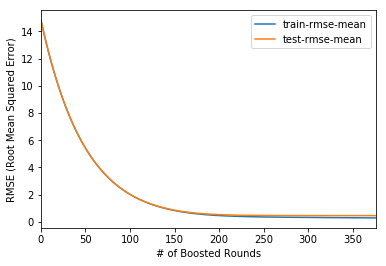

In [83]:
plt.figure(figsize=(14,4),dpi=80)
cv_result[['train-rmse-mean', 'test-rmse-mean']].plot()
plt.xlabel('# of Boosted Rounds')
plt.ylabel('RMSE (Root Mean Squared Error)')
plt.show()

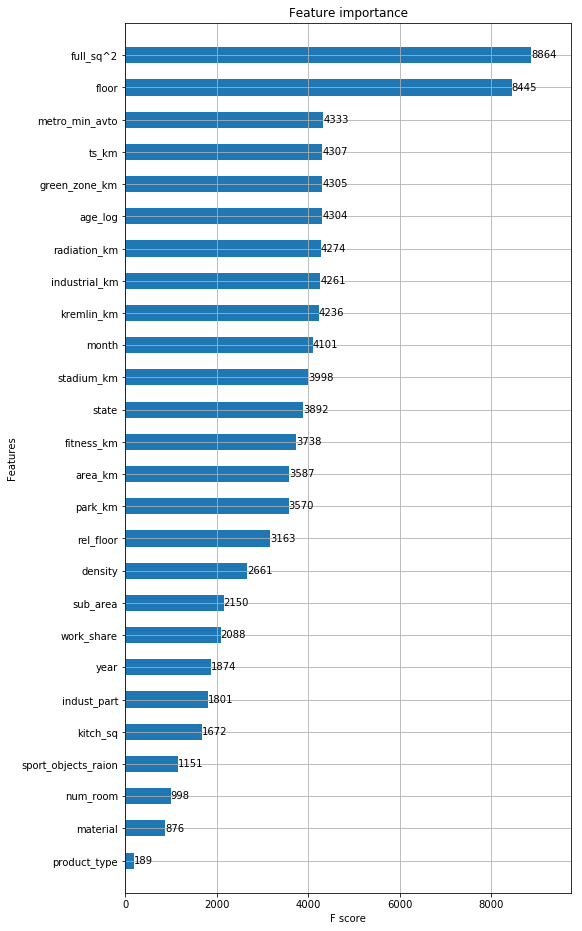

In [82]:
num_boost_round = 395

model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_round)

fig, ax = plt.subplots(1, 1, figsize=(8, 16))
xgb.plot_importance(model, height=0.5, ax=ax)

In [84]:
y_pred = model.predict(dtest)

In [85]:
y_test = np.expm1(y_pred)

In [91]:
y_test[0:5], len(y_test)

(array([ 5136317. ,  8643858. ,  4785830. ,  5786797.5,  5252122.5], dtype=float32),
 7662)

In [86]:
sample = pd.read_csv('../sample_submission.csv', index_col=False)

sample.head(10)

,id,price_doc
0,30474,7118500.41
1,30475,7118500.41
2,30476,7118500.41
3,30477,7118500.41
4,30478,7118500.41
5,30479,7118500.41
6,30480,7118500.41
7,30481,7118500.41
8,30482,7118500.41
9,30483,7118500.41


In [92]:
sample['price_doc'] = y_test

In [93]:
sample.to_csv('./xgboost_nosplit_053017.csv', index=False)